In [1]:
""" Import libraries. """
import os

os.makedirs("outputs", exist_ok=True)
from dotenv import load_dotenv

load_dotenv();  # TODO: make common example prep function

from earth2studio.data import GFS
from earth2studio.io import XarrayBackend
from earth2studio.models.px import SFNO
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import earth2studio.run as run

In [ ]:
from datetime import datetime
from earth2studio.utils.type import TimeArray, VariableArray
import xarray as xr

class DataSetFile:
    """A local xarray dataset file data source. This file should be compatable with
    xarray. For example, a netCDF file.

    Parameters
    ----------
    file_path : str
        Path to xarray dataset compatible file.
    array_name : str
        Data array name in xarray dataset
    """

    def __init__(self, file_path: str, **xr_args ):
        self.file_path = file_path
        self.ds = xr.open_dataset(self.file_path, **xr_args)

    def __call__(
        self,
        time: datetime | list[datetime] | TimeArray,
        variable: str | list[str] | VariableArray,
    ) -> xr.DataArray:
        """Function to get data.

        Parameters
        ----------
        time : datetime | list[datetime] | TimeArray
            Timestamps to return data for.
        variable : str | list[str] | VariableArray
            Strings or list of strings that refer to variables to return.

        Returns
        -------
        xr.DataArray
            Loaded data array
        """
        # loop over variables and concatenate the data arrays
        da_list = [self.ds[v].sel(time=np.atleast_1d(time)) for v in variable]
        da = xr.concat(da_list, dim="variable")
        da = da.assign_coords(variable=variable)
        # reorder to time variable lat lon
        da = da.transpose("time", "variable", "lat", "lon")
        return da

In [3]:
""" Set up the model """
# Load the default model package which downloads the check point from NGC
package = SFNO.load_default_package()
model = SFNO.load_model(package)


In [4]:
""" Set up the data sources. """
unperturbed_data = DataSetFile('/N/slate/jmelms/projects/HM24_initial_conditions/IC_files/sfno_DJF_IC.nc')

In [5]:
""" Set up tendency reversion. """
# set up IO
dummy_io = XarrayBackend()

# set up a hook function that appends the model state to a list
states = []
def append_state(x, coords):
    """ Appends the states to a list"""
    states.append(x)
    return x, coords

model.rear_hook = append_state
model.front_hook = append_state

# run the model for one step; this will populate the states[] list above
nsteps = 1
io = run.deterministic(["2000-01-01"], nsteps, model, unperturbed_data, dummy_io)

# get the recurrent perturbation
rpert = states[0] - states[1]

2025-08-05 20:00:14.911 | INFO     | earth2studio.run:deterministic:75 - Running simple workflow!
2025-08-05 20:00:14.912 | INFO     | earth2studio.run:deterministic:82 - Inference device: cuda
2025-08-05 20:00:18.638 | SUCCESS  | earth2studio.run:deterministic:106 - Fetched data from DataSetFile
2025-08-05 20:00:19.287 | INFO     | earth2studio.run:deterministic:136 - Inference starting!


Running inference: 100%|█████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.41s/it]

2025-08-05 20:00:34.108 | SUCCESS  | earth2studio.run:deterministic:146 - Inference complete


2025-08-05 20:00:40.668 | INFO     | earth2studio.run:deterministic:75 - Running simple workflow!
2025-08-05 20:00:40.668 | INFO     | earth2studio.run:deterministic:82 - Inference device: cuda
2025-08-05 20:00:41.186 | SUCCESS  | earth2studio.run:deterministic:106 - Fetched data from DataSetFile
2025-08-05 20:00:41.676 | INFO     | earth2studio.run:deterministic:136 - Inference starting!


Running inference: 100%|█████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


2025-08-05 20:00:44.273 | SUCCESS  | earth2studio.run:deterministic:146 - Inference complete
<xarray.Dataset> Size: 584B
Dimensions:  ()
Data variables: (12/73)
    u10m     float64 8B 4.768e-07
    v10m     float64 8B 4.768e-07
    u100m    float64 8B 4.768e-07
    v100m    float64 8B 4.768e-07
    t2m      float64 8B 0.0
    sp       float64 8B 0.0
    ...       ...
    q500     float64 8B 5.821e-11
    q600     float64 8B 1.164e-10
    q700     float64 8B 2.328e-10
    q850     float64 8B 5.821e-11
    q925     float64 8B 2.91e-11
    q1000    float64 8B 2.91e-11


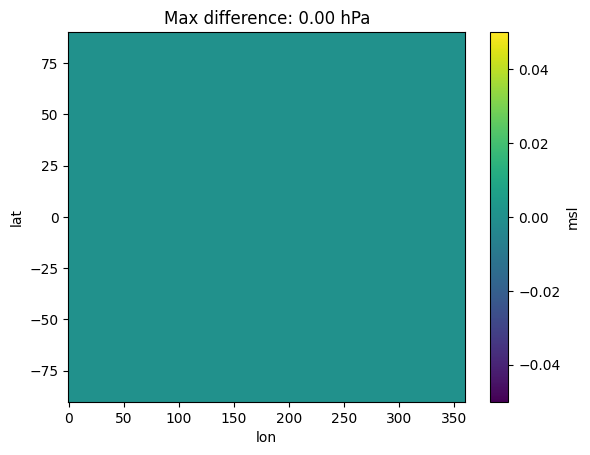

In [7]:
""" Verify that tendency reversion works. """

# set up a post-model hook function that reverts the tendency
def tendency_reversion(x, coords):
    """ Reverts the tendency to the first state """
    return x + rpert, coords

# set up a hook function that returns the input as is
def identity(x, coords):
    """ Returns the input as is """
    return x, coords

# reset the model hooks
model.front_hook = identity
model.rear_hook = tendency_reversion

nsteps = 1
io = XarrayBackend()
io = run.deterministic(["2000-01-01"], nsteps, model, unperturbed_data, io)
ds = io.root

# plot the difference between the timesteps
ds_diff = ds.diff(dim = "lead_time")
ds_diff['msl'].plot()
plt.title(f"Max difference: {ds_diff['msl'].max().values:.2f} hPa")
print(ds_diff.max())

In [ ]:
""" Run the model with the perturbed data and tendency reversion. """

# reset the model hooks for tendency reversion
model.front_hook = identity
model.rear_hook = tendency_reversion

nsteps = 10 * 4 # steps, 10 days at 4 steps per day
io = XarrayBackend()
io = run.deterministic(["2000-01-01"], nsteps, model, unperturbed_data, io)

2025-08-05 20:03:04.912 | INFO     | earth2studio.run:deterministic:75 - Running simple workflow!
2025-08-05 20:03:04.912 | INFO     | earth2studio.run:deterministic:82 - Inference device: cuda
2025-08-05 20:03:05.412 | SUCCESS  | earth2studio.run:deterministic:106 - Fetched data from DataSetFile
2025-08-05 20:03:11.716 | INFO     | earth2studio.run:deterministic:136 - Inference starting!


Running inference: 100%|███████████████████████████████████████████████| 41/41 [01:08<00:00,  1.68s/it]

2025-08-05 20:04:20.588 | SUCCESS  | earth2studio.run:deterministic:146 - Inference complete


In [11]:
ds = io.root
import os
os.makedirs("outputs", exist_ok=True)
ds.to_netcdf("outputs/unperturbed.nc")

Lead Time: 0 seconds
Lead Time: 21600 seconds
Lead Time: 43200 seconds
Lead Time: 64800 seconds
Lead Time: 86400 seconds
Lead Time: 108000 seconds
Lead Time: 129600 seconds
Lead Time: 151200 seconds
Lead Time: 172800 seconds
Lead Time: 194400 seconds
Lead Time: 216000 seconds
Lead Time: 237600 seconds
Lead Time: 259200 seconds
Lead Time: 280800 seconds
Lead Time: 302400 seconds
Lead Time: 324000 seconds
Lead Time: 345600 seconds
Lead Time: 367200 seconds
Lead Time: 388800 seconds
Lead Time: 410400 seconds
Lead Time: 432000 seconds
Lead Time: 453600 seconds
Lead Time: 475200 seconds
Lead Time: 496800 seconds
Lead Time: 518400 seconds
Lead Time: 540000 seconds
Lead Time: 561600 seconds
Lead Time: 583200 seconds
Lead Time: 604800 seconds
Lead Time: 626400 seconds
Lead Time: 648000 seconds
Lead Time: 669600 seconds
Lead Time: 691200 seconds
Lead Time: 712800 seconds
Lead Time: 734400 seconds
Lead Time: 756000 seconds
Lead Time: 777600 seconds
Lead Time: 799200 seconds
Lead Time: 820800 sec

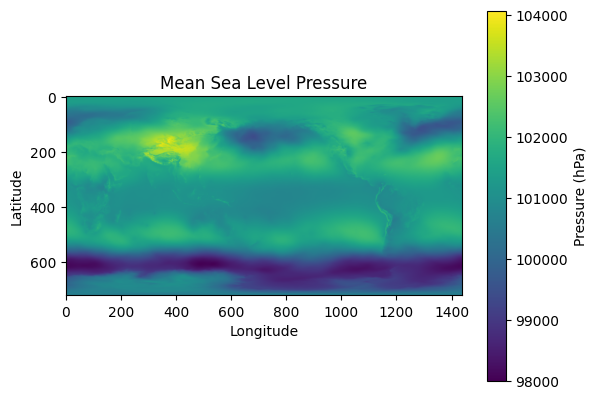

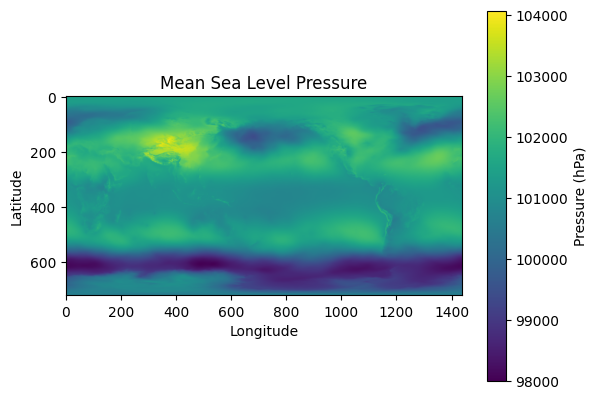

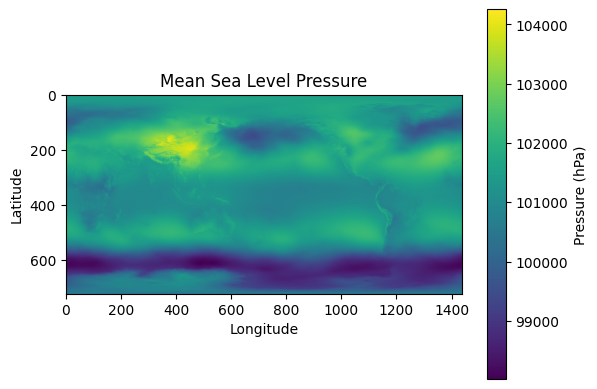

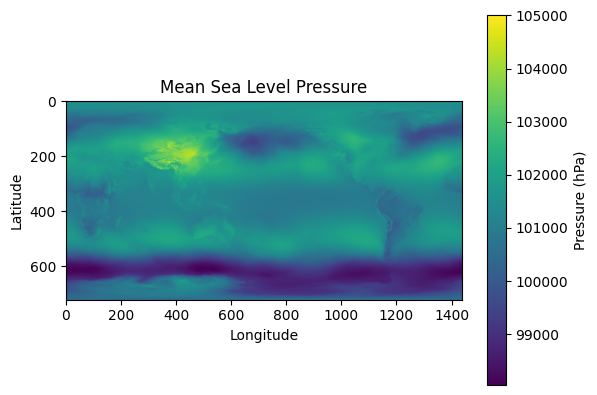

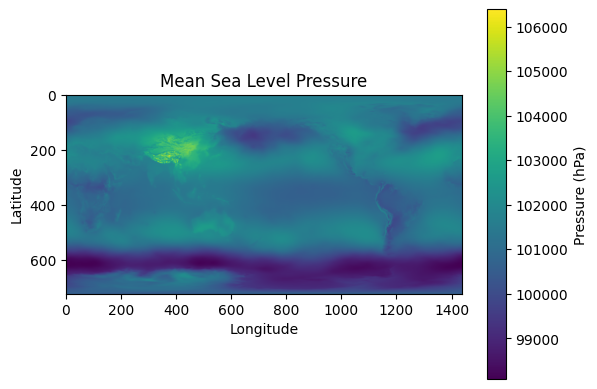

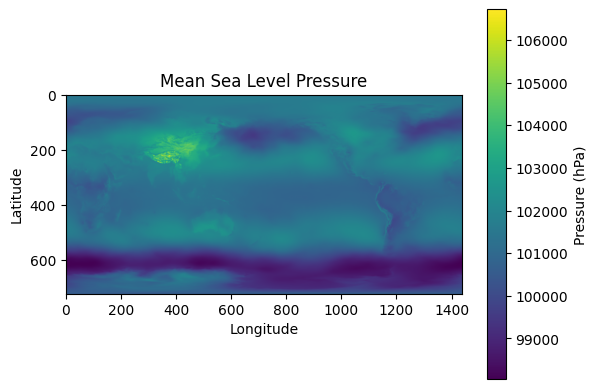

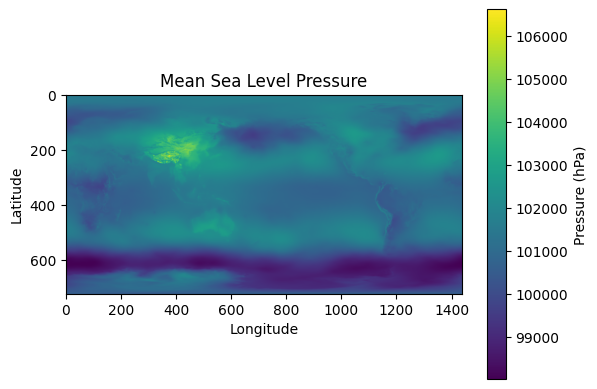

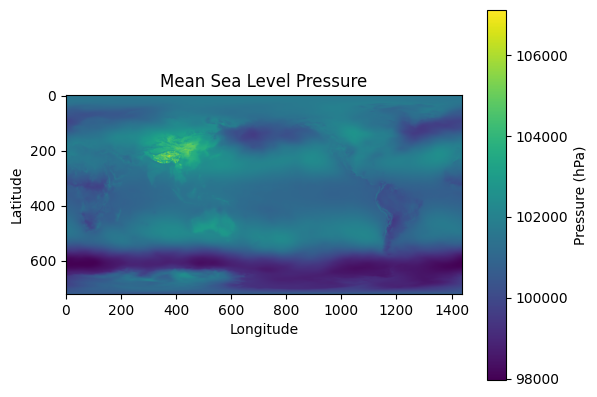

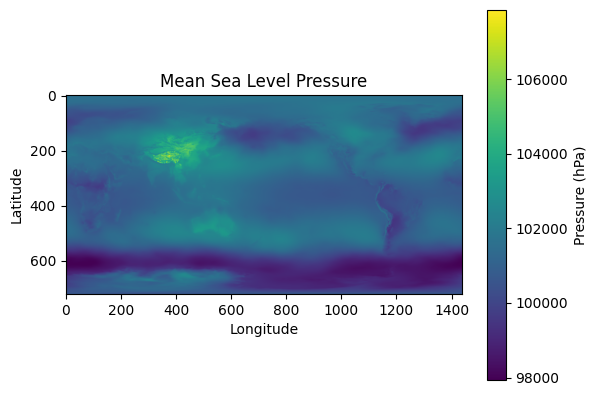

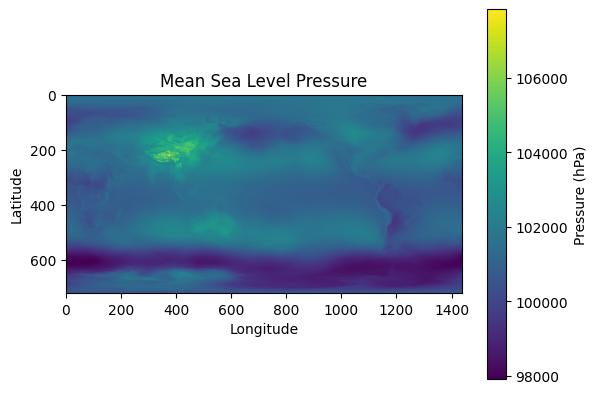

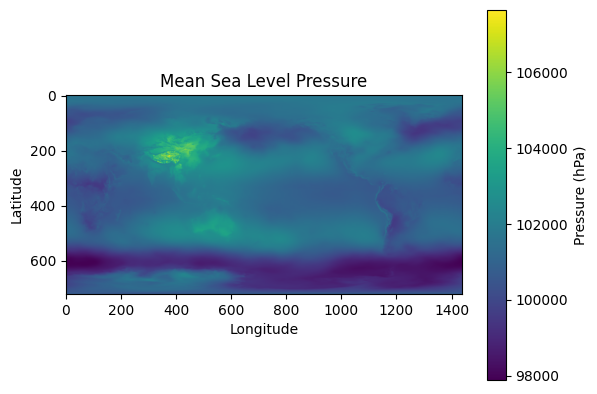

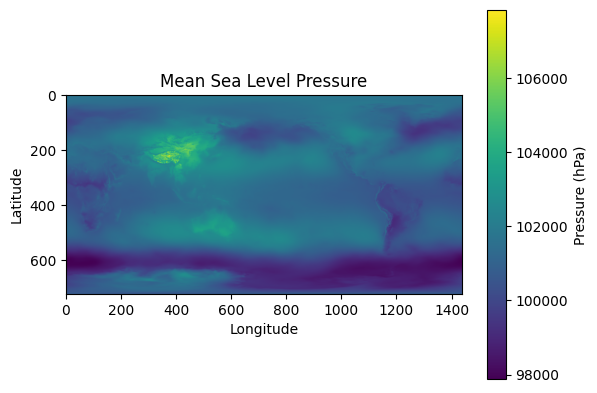

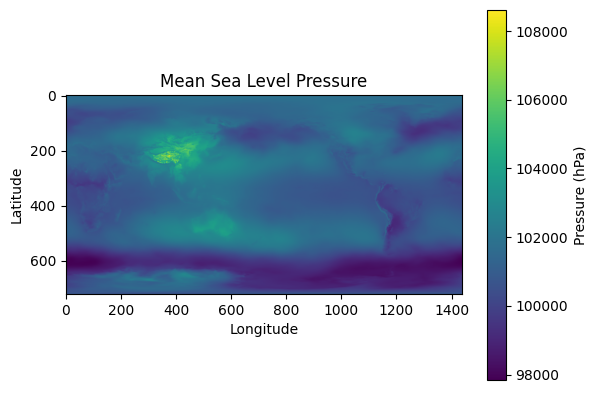

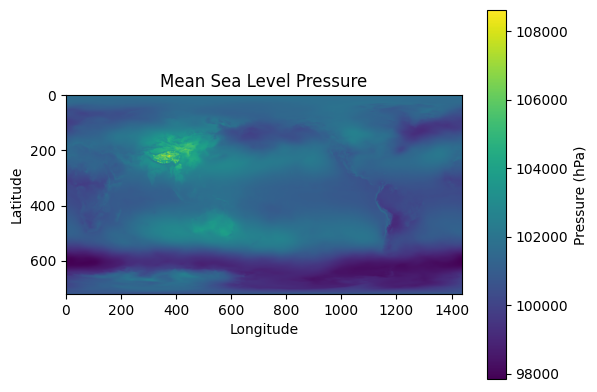

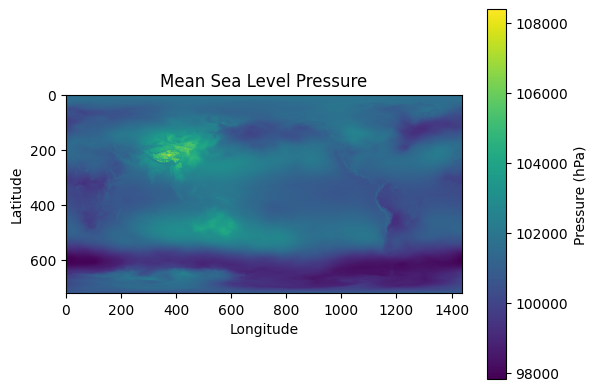

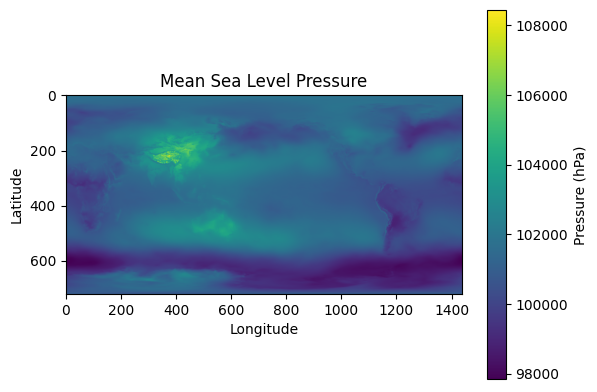

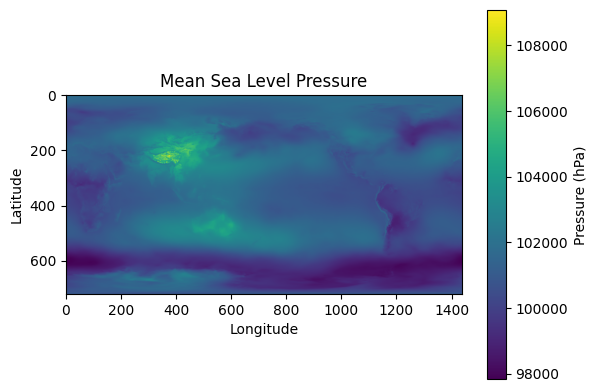

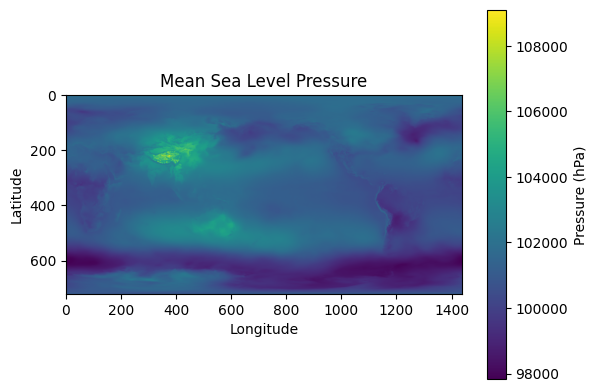

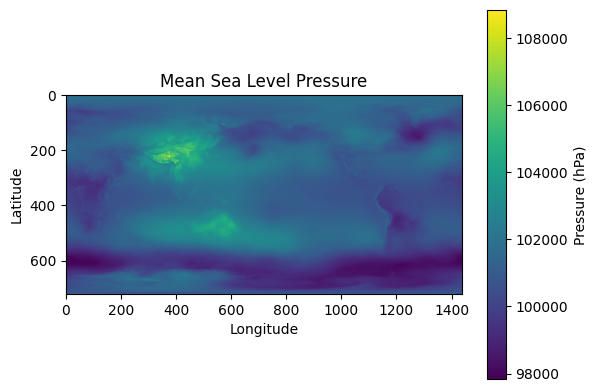

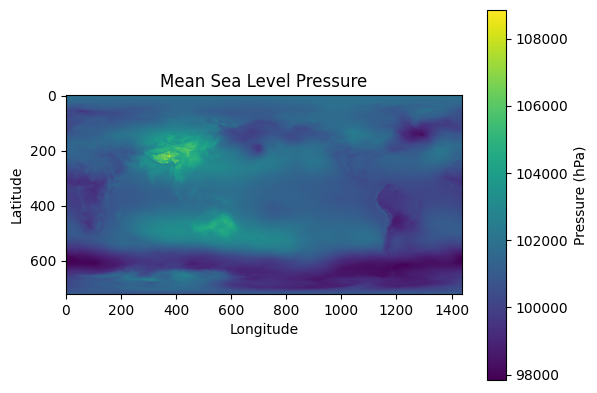

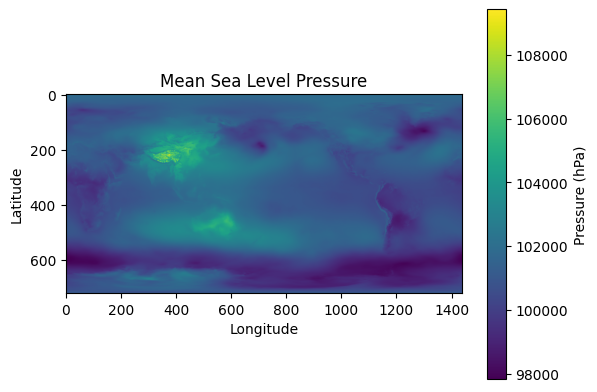

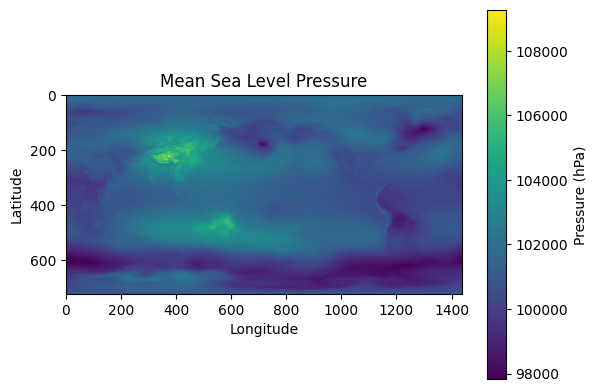

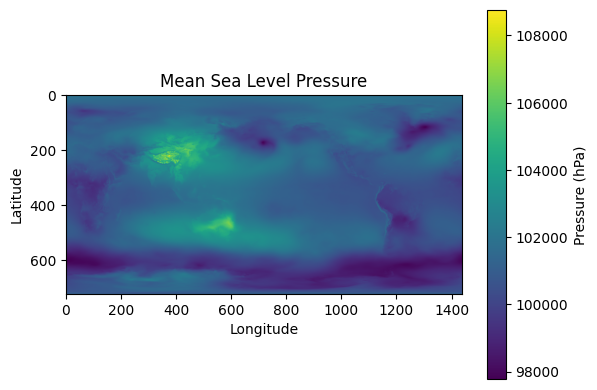

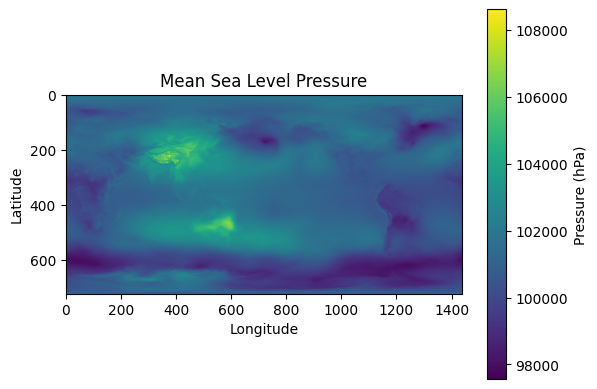

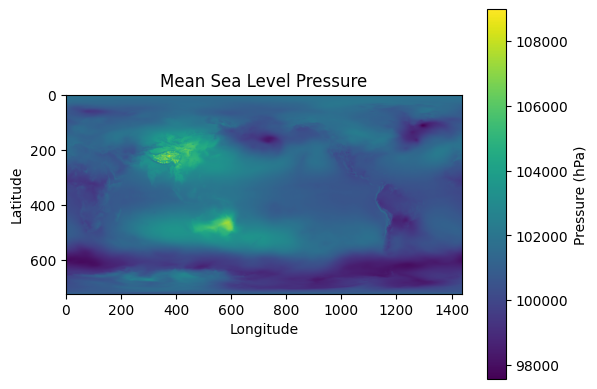

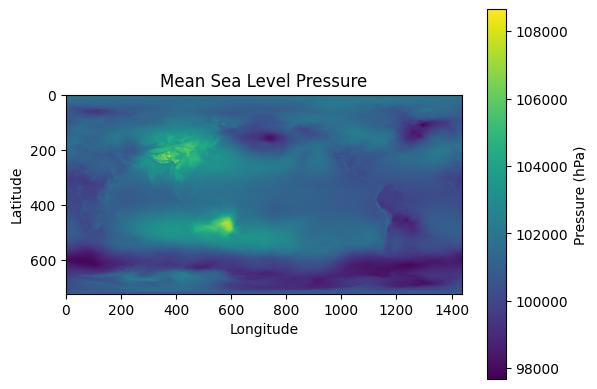

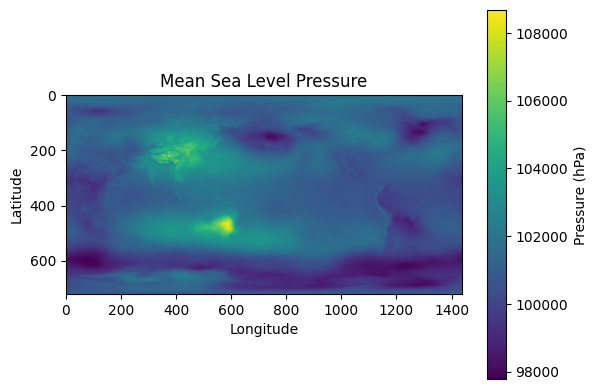

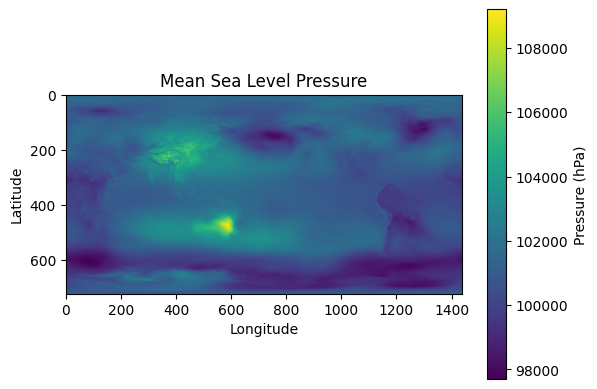

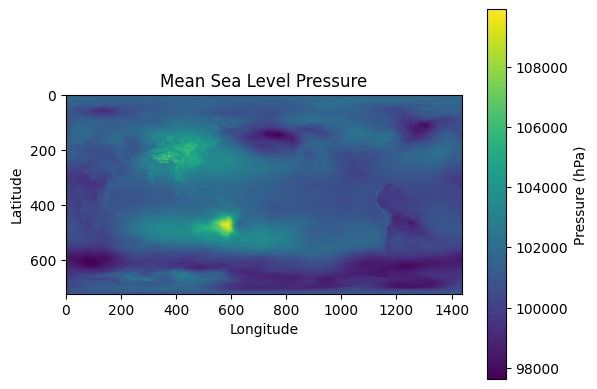

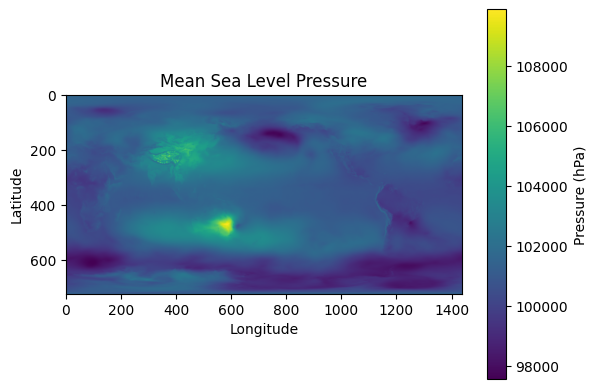

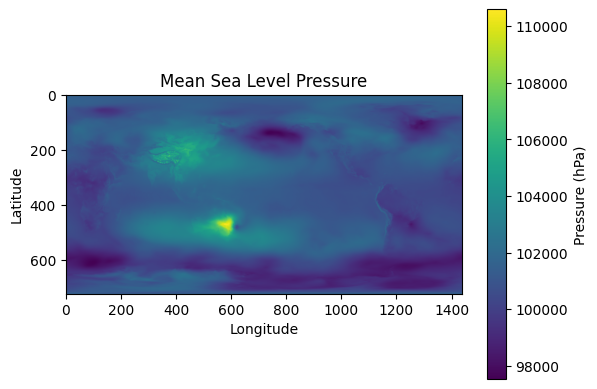

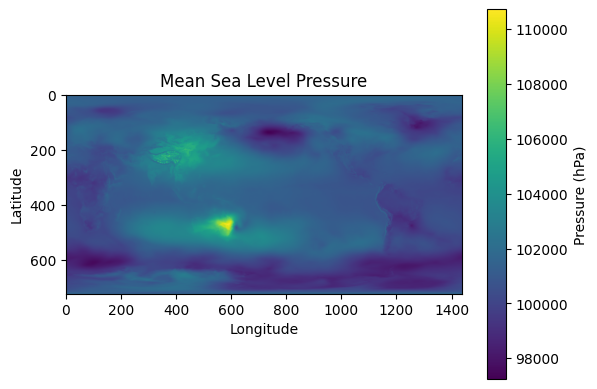

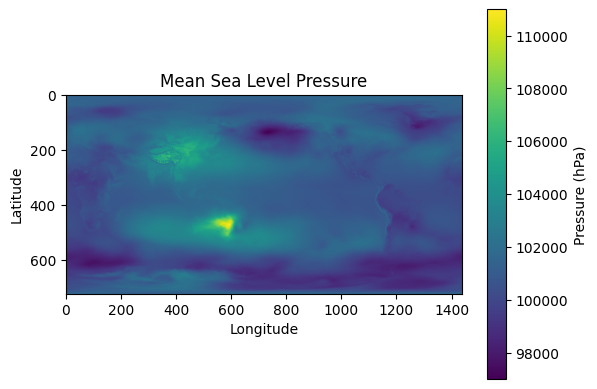

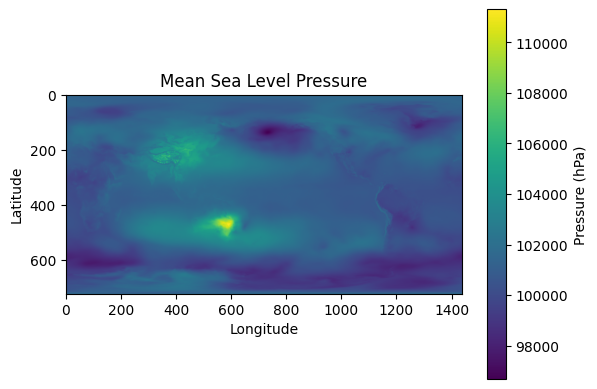

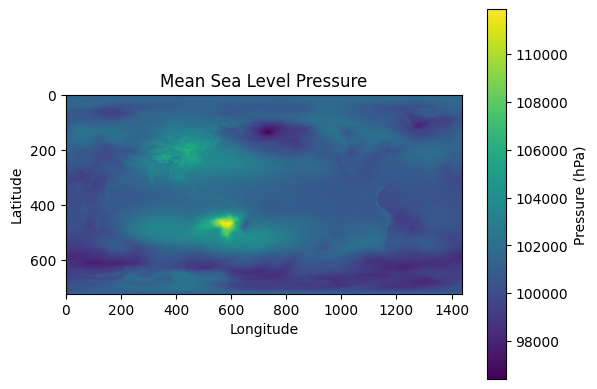

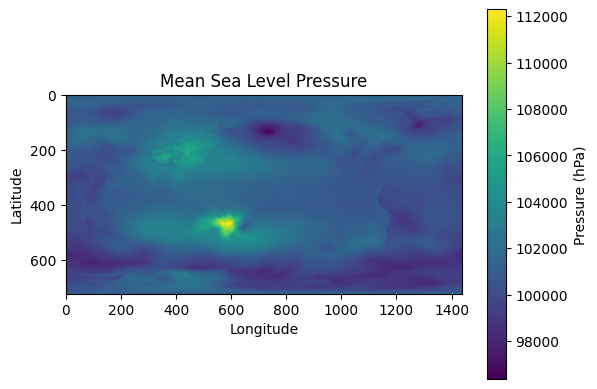

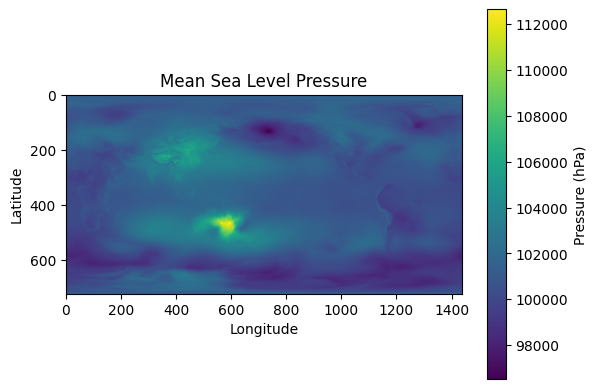

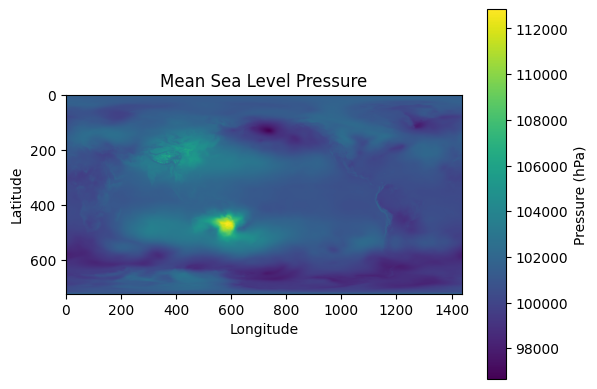

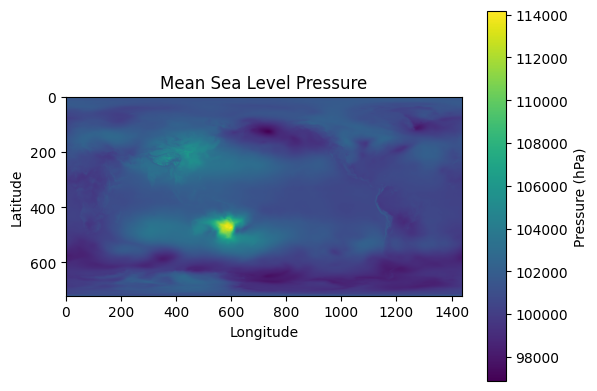

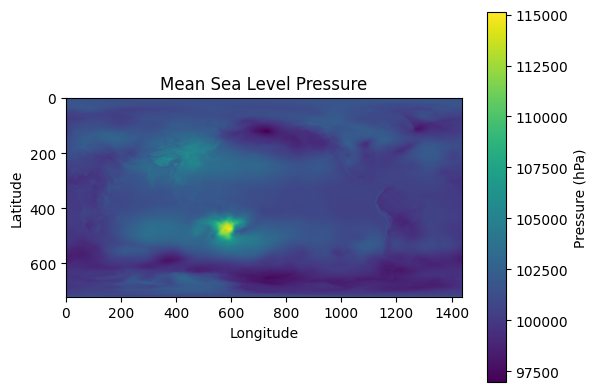

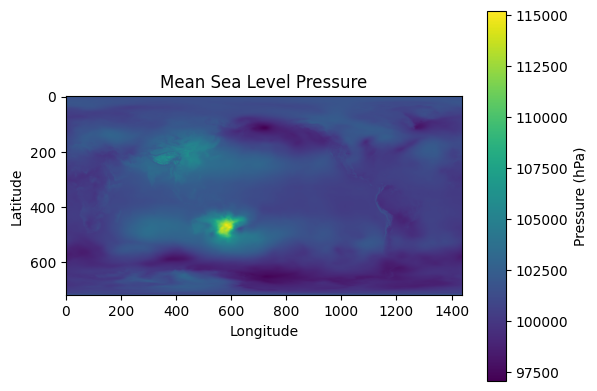

In [20]:
for t in ds.lead_time.values:
    print(f"Lead Time: {t}")
    var = ds.msl.sel(lead_time=t).squeeze().values
    fig, ax = plt.subplots()
    im = ax.imshow(var, label=f"Lead Time: {t}")
    ax.set_title("Mean Sea Level Pressure")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    fig.colorbar(im, ax=ax, label="Pressure (hPa)")
    plt.savefig(f"outputs/mean_sea_level_pressure_{t}.png")